In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Training parameters
learning_rate = 0.0002
batch_size = 128
epochs = 215

# Network parameters
image_dim = 28 * 28
gen_hidd_dim = 256
disc_hidd_dim = 256
z_noise_dim = 100  # Noise data points

In [3]:
# Generator Network
class Generator(nn.Module):

    def __init__(
        self,
        noise_dim,
        hidden_dim,
        image_dim,
        ):
        super().__init__()

        self.ff1 = nn.Linear(noise_dim, hidden_dim)
        self.ff2 = nn.Linear(hidden_dim, image_dim)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        x = F.leaky_relu(self.ff1(x), 0.2)
        x = F.tanh(self.ff2(x))

        return x


# Discriminator Network
class Discriminator(nn.Module):

    def __init__(
        self,
        image_dim,
        hidden_dim,
        ):
        super().__init__()

        self.ff1 = nn.Linear(image_dim, hidden_dim)
        self.ff2 = nn.Linear(hidden_dim, 1)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        x = F.leaky_relu(self.ff1(x), 0.2)
        x = self.ff2(x)

        return x


In [10]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    )

100%|██████████| 26421880/26421880 [00:27<00:00, 955332.88it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 182325.59it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:10<00:00, 439560.53it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11754097.44it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([1, 28, 28]) 9


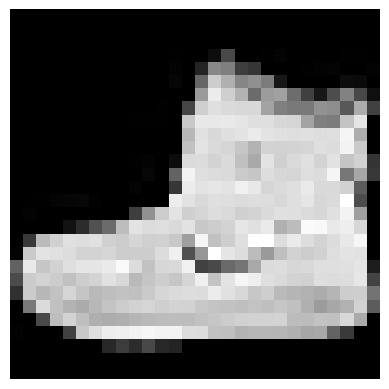

In [5]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

For the discriminator:
$$ \max_{D} \left\{ \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_{z}}[\log (1 - D(G(z)))] \right\} $$
For the generator:
$$ \min_{G} \left\{ \mathbb{E}_{z \sim p_{z}}[\log (1 - D(G(z)))] \right\} $$
or equivalently:
$$ \max_{G} \left\{ \mathbb{E}_{z \sim p_{z}}[\log D(G(z))] \right\} $$
where $p_{data}$ is the data distribution, $p_{z}$ is the noise distribution, $G$ is the generator network, and $D$ is the discriminator network.

The code below approximates the discriminator and generator objective functions using a Monte Carlo approximation.

In [6]:
def loss_discriminator(img, model_d, model_g, opt_d):

    # real loss
    real_targets = torch.ones(img.size(0), 1)
    real_preds = model_d(img)
    real_loss = F.binary_cross_entropy_with_logits(real_preds, real_targets)

    # fake images
    noise = torch.tensor(np.random.uniform(-1, 1, size=(img.size(0), z_noise_dim))).float()
    fake_imgs = model_g(noise)

    # fake loss
    fake_targets = torch.zeros(img.size(0), 1)
    fake_preds = model_d(fake_imgs)
    fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_targets)

    # total loss
    loss = real_loss + fake_loss

    # update discriminator
    opt_d.zero_grad()
    loss.backward()
    opt_d.step()

    return loss
    

def loss_generator(model_d, model_g, opt_g):

    # fake images
    noise = torch.tensor(np.random.uniform(-1, 1, size=(img.size(0), z_noise_dim))).float()
    fake_imgs = model_g(noise)

    # fake loss
    fake_targets = torch.ones(img.size(0), 1)
    fake_preds = model_d(fake_imgs)
    fake_loss = F.binary_cross_entropy_with_logits(fake_preds, fake_targets)

    # update generator
    opt_g.zero_grad()
    fake_loss.backward()
    opt_g.step()

    return fake_loss

In [7]:
# Initialize models
generator = Generator(z_noise_dim, gen_hidd_dim, image_dim)
discriminator = Discriminator(image_dim, disc_hidd_dim)

# Optimizers
opt_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loader
data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,

    )

# Training
for epoch in range(epochs):
    for batch_idx, (img, _) in enumerate(data_loader):

        img = img.view(img.shape[0], -1)  # flatten
        img = 2 * img - 1  # normalize to [-1, 1] from [0, 1]

        # loss discriminator
        loss_d = loss_discriminator(img, discriminator, generator, opt_d)

        # loss generator
        loss_g = loss_generator(discriminator, generator, opt_g)

    # print loss
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss D: {loss_d}, Loss G: {loss_g}')   

Epoch: 0, Loss D: 0.5775367021560669, Loss G: 1.3487625122070312
Epoch: 10, Loss D: 0.8367063999176025, Loss G: 1.1618694067001343
Epoch: 20, Loss D: 0.6431962251663208, Loss G: 1.810083031654358
Epoch: 30, Loss D: 0.6959147453308105, Loss G: 2.141814708709717
Epoch: 40, Loss D: 0.7338207960128784, Loss G: 2.193708658218384
Epoch: 50, Loss D: 0.721940815448761, Loss G: 1.6047344207763672
Epoch: 60, Loss D: 0.761450469493866, Loss G: 1.754541039466858
Epoch: 70, Loss D: 0.8221719264984131, Loss G: 1.5808300971984863
Epoch: 80, Loss D: 0.8280654549598694, Loss G: 1.3812193870544434
Epoch: 90, Loss D: 0.804298996925354, Loss G: 1.4431482553482056
Epoch: 100, Loss D: 0.824460506439209, Loss G: 1.9579190015792847
Epoch: 110, Loss D: 0.765851616859436, Loss G: 1.5276960134506226
Epoch: 120, Loss D: 0.7017614245414734, Loss G: 1.3071266412734985
Epoch: 130, Loss D: 0.8161087036132812, Loss G: 1.645940899848938
Epoch: 140, Loss D: 0.9915169477462769, Loss G: 1.8606575727462769
Epoch: 150, Loss

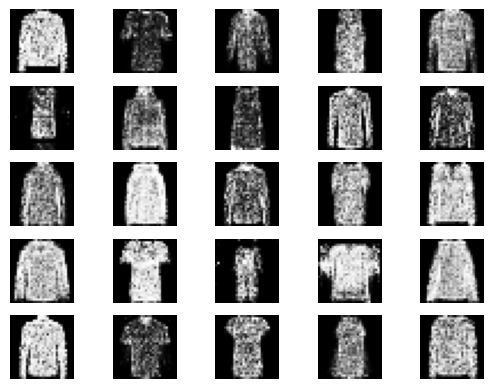

In [9]:
# Generate images
noise = torch.tensor(np.random.uniform(-1, 1, size=(25, z_noise_dim))).float()
fake_imgs = generator(noise)
fake_imgs = fake_imgs.view(fake_imgs.size(0), 28, 28).data

# Normalize to [0, 1]
fake_imgs = (fake_imgs + 1) / 2

# Plot
fig, ax = plt.subplots(5, 5)
k = 0
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(fake_imgs[k], cmap='gray')
        ax[i, j].axis('off')
        k += 1
plt.show()